##IMAGE COLORIZER

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  print(torch.cuda.current_device())
  print(torch.cuda.device(0))
  print(torch.cuda.device_count())
  print(torch.cuda.get_device_name(0))
else:
  print("No NVIDIA driver found. Using CPU")

0
1
Tesla T4


In [3]:
# Load the CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:03<00:00, 48.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


* in_channels=1: The input to this layer has 1 channel (grayscale image).
* out_channels=64: The output of this layer will have 64 channels.
* kernel_size=5: The size of the convolutional kernel is 5x5.
* stride=1: The kernel moves 1 pixel at a time.
* padding=4: 4 pixels of padding are added around the input.
* dilation=2: The spacing between kernel elements is 2.

In [4]:
# Define the colorization model
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=4, dilation=2)
        self.conv4 = nn.Conv2d(128, 3, kernel_size=5, stride=1, padding=4, dilation=2)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.relu(self.conv3(x))
        x = torch.sigmoid(self.conv4(x))
        return x

        ''' ReLU (Rectified Linear Unit) is a non-linear function that introduces non-linearity into the network, which is crucial for learning complex patterns.

        Sigmoid is often used in the output layer for binary classification tasks, but in this case, it's likely used to ensure the output values are in the range [0, 1], representing pixel intensities.
        '''

In [5]:
model = ColorizationNet().to(device)  # device is defined above

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert RGB image to grayscale
def rgb_to_gray(img):
    return img.mean(dim=1, keepdim=True) # bw has 1 dimension, keep-dimensions

    '''
    - model.parameters() provides the optimizer with access to the model's adjustable parameters.
    - lr=0.001 sets the learning rate, controlling the step size the optimizer takes when updating the model's parameters. A smaller learning rate leads to slower but potentially more stable training.
    '''


In [6]:
# Training loop
EPOCHS = 30
for epoch in range(EPOCHS):
    for i, (images, _) in enumerate(train_loader):
        grayscale_images = rgb_to_gray(images).to(device)
        images = images.to(device)

        # Forward pass

        outputs = model(grayscale_images)
        loss = criterion(outputs, images)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print statistics
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

print("Finished Training")

'''
    train_loader is responsible for feeding the training data to the model in batches.
    enumerate provides a counter (i) for each batch.
    images contains the batch of color images.
    _ is used as a placeholder for the labels (which are not needed for this unsupervised colorization task).
'''


Epoch [1/30], Step [1/782], Loss: 0.0649
Epoch [1/30], Step [101/782], Loss: 0.0080
Epoch [1/30], Step [201/782], Loss: 0.0062
Epoch [1/30], Step [301/782], Loss: 0.0064
Epoch [1/30], Step [401/782], Loss: 0.0042
Epoch [1/30], Step [501/782], Loss: 0.0067
Epoch [1/30], Step [601/782], Loss: 0.0054
Epoch [1/30], Step [701/782], Loss: 0.0060
Epoch [2/30], Step [1/782], Loss: 0.0050
Epoch [2/30], Step [101/782], Loss: 0.0062
Epoch [2/30], Step [201/782], Loss: 0.0075
Epoch [2/30], Step [301/782], Loss: 0.0048
Epoch [2/30], Step [401/782], Loss: 0.0049
Epoch [2/30], Step [501/782], Loss: 0.0044
Epoch [2/30], Step [601/782], Loss: 0.0048
Epoch [2/30], Step [701/782], Loss: 0.0066
Epoch [3/30], Step [1/782], Loss: 0.0059
Epoch [3/30], Step [101/782], Loss: 0.0045
Epoch [3/30], Step [201/782], Loss: 0.0049
Epoch [3/30], Step [301/782], Loss: 0.0038
Epoch [3/30], Step [401/782], Loss: 0.0057
Epoch [3/30], Step [501/782], Loss: 0.0052
Epoch [3/30], Step [601/782], Loss: 0.0058
Epoch [3/30], Ste

'\n    train_loader is responsible for feeding the training data to the model in batches.\n    enumerate provides a counter (i) for each batch.\n    images contains the batch of color images.\n    _ is used as a placeholder for the labels (which are not needed for this unsupervised colorization task).\n'

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    # Convert from Tensor image and display
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    if len(img.shape) == 2:  # grayscale image
        plt.imshow(npimg, cmap='gray')
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualize_all_three(original_images, grayscale_images, colorized_images, n=5):
    """
    Display grayscale, colorized, and original images side by side.
    n: number of images to display from the batch
    """
    fig = plt.figure(figsize=(3*n, 4))
    for i in range(n):
        # Display original image
        ax = plt.subplot(1, 3*n, 3*i + 1)
        imshow(original_images[i])
        ax.set_title("Original")
        ax.axis("off")

        # Display original grayscale image
        ax = plt.subplot(1, 3*n, 3*i + 2)
        imshow(grayscale_images[i])
        ax.set_title("Grayscale")
        ax.axis("off")

        # Display colorized image
        ax = plt.subplot(1, 3*n, 3*i + 3)
        imshow(colorized_images[i])
        ax.set_title("Colorized")
        ax.axis("off")

    plt.tight_layout()
    plt.show()


def torch_rgb_to_hsv(rgb):
    """
    Convert an RGB image tensor to HSV.

    Parameters:
    - rgb: tensor of shape (batch_size, 3, height, width) in RGB format in the range [0, 1].

    Returns:
    - hsv: tensor of same shape in HSV format in the range [0, 1].
    """
    r, g, b = rgb[:, 0, :, :], rgb[:, 1, :, :], rgb[:, 2, :, :]
    max_val, _ = torch.max(rgb, dim=1)
    min_val, _ = torch.min(rgb, dim=1)
    diff = max_val - min_val

    # Compute H
    h = torch.zeros_like(r)
    mask = (max_val == r) & (g >= b)
    h[mask] = (g[mask] - b[mask]) / diff[mask]
    mask = (max_val == r) & (g < b)
    h[mask] = (g[mask] - b[mask]) / diff[mask] + 6.0
    mask = max_val == g
    h[mask] = (b[mask] - r[mask]) / diff[mask] + 2.0
    mask = max_val == b
    h[mask] = (r[mask] - g[mask]) / diff[mask] + 4.0
    h = h / 6.0
    h[diff == 0.0] = 0.0

    # Compute S
    s = torch.zeros_like(r)
    s[diff != 0.0] = diff[diff != 0.0] / max_val[diff != 0.0]

    # V is just max_val
    v = max_val

    return torch.stack([h, s, v], dim=1)


def torch_hsv_to_rgb(hsv):
    """
    Convert an HSV image tensor to RGB.

    Parameters:
    - hsv: tensor of shape (batch_size, 3, height, width) in HSV format in the range [0, 1].

    Returns:
    - rgb: tensor of same shape in RGB format in the range [0, 1].
    """
    h, s, v = hsv[:, 0, :, :], hsv[:, 1, :, :], hsv[:, 2, :, :]
    i = (h * 6.0).floor()
    f = h * 6.0 - i
    p = v * (1.0 - s)
    q = v * (1.0 - s * f)
    t = v * (1.0 - s * (1.0 - f))

    i_mod = i % 6
    r = torch.zeros_like(h)
    g = torch.zeros_like(h)
    b = torch.zeros_like(h)

    r[i_mod == 0.0] = v[i_mod == 0.0]
    g[i_mod == 0.0] = t[i_mod == 0.0]
    b[i_mod == 0.0] = p[i_mod == 0.0]

    r[i_mod == 1.0] = q[i_mod == 1.0]
    g[i_mod == 1.0] = v[i_mod == 1.0]
    b[i_mod == 1.0] = p[i_mod == 1.0]

    r[i_mod == 2.0] = p[i_mod == 2.0]
    g[i_mod == 2.0] = v[i_mod == 2.0]
    b[i_mod == 2.0] = t[i_mod == 2.0]

    r[i_mod == 3.0] = p[i_mod == 3.0]
    g[i_mod == 3.0] = q[i_mod == 3.0]
    b[i_mod == 3.0] = v[i_mod == 3.0]

    r[i_mod == 4.0] = t[i_mod == 4.0]
    g[i_mod == 4.0] = p[i_mod == 4.0]
    b[i_mod == 4.0] = v[i_mod == 4.0]

    r[i_mod == 5.0] = v[i_mod == 5.0]
    g[i_mod == 5.0] = p[i_mod == 5.0]
    b[i_mod == 5.0] = q[i_mod == 5.0]

    return torch.stack([r, g, b], dim=1)

def exaggerate_colors(images, saturation_factor=1.5, value_factor=1.2):
    """
    Exaggerate the colors of RGB images.

    Parameters:
    - images: tensor of shape (batch_size, 3, height, width) in RGB format.
    - saturation_factor: factor by which to increase the saturation. Default is 1.5.
    - value_factor: factor by which to increase the value/brightness. Default is 1.2.

    Returns:
    - color_exaggerated_images: tensor of same shape as input, with exaggerated colors.
    """
    # Convert images to the range [0, 1]
    images = (images + 1) / 2.0

    # Convert RGB images to HSV
    images_hsv = torch_rgb_to_hsv(images)

    # Increase the saturation and value components
    images_hsv[:, 1, :, :] = torch.clamp(images_hsv[:, 1, :, :] * saturation_factor, 0, 1)
    images_hsv[:, 2, :, :] = torch.clamp(images_hsv[:, 2, :, :] * value_factor, 0, 1)

    # Convert the modified HSV images back to RGB
    color_exaggerated_images = torch_hsv_to_rgb(images_hsv)

    # Convert images back to the range [-1, 1]
    color_exaggerated_images = color_exaggerated_images * 2.0 - 1.0

    return color_exaggerated_images



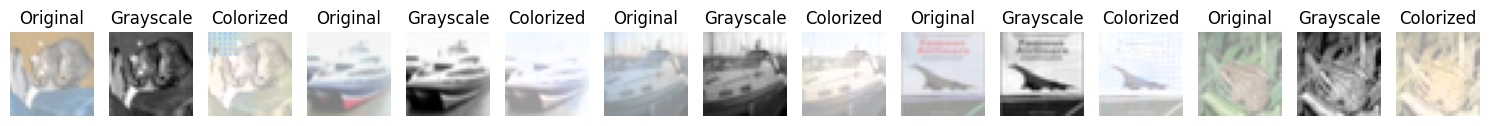

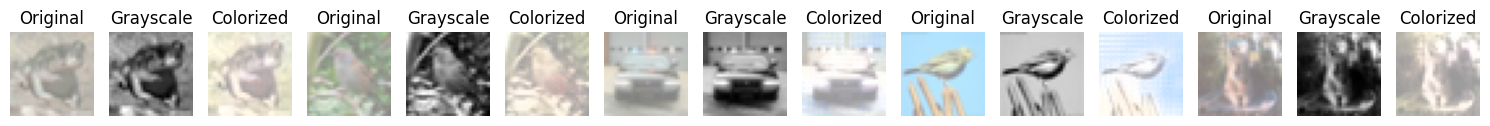

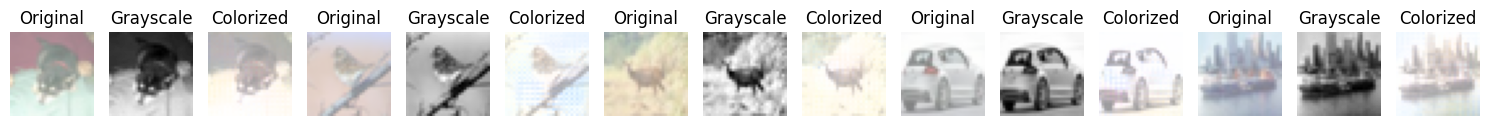

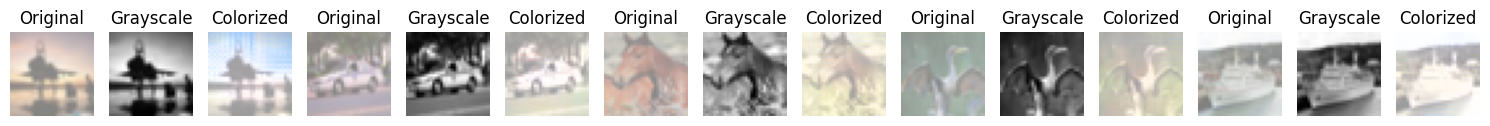

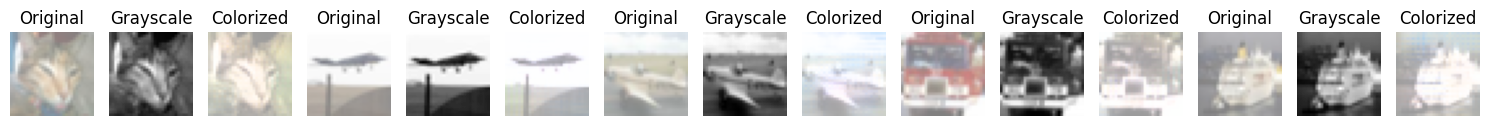

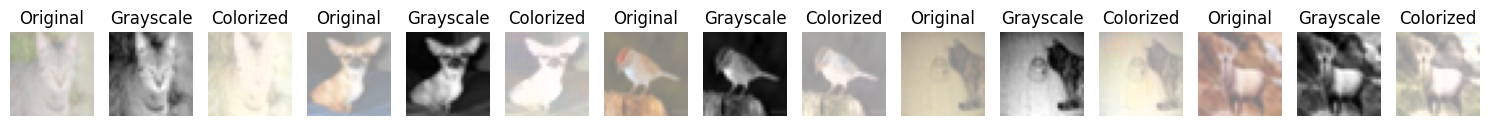

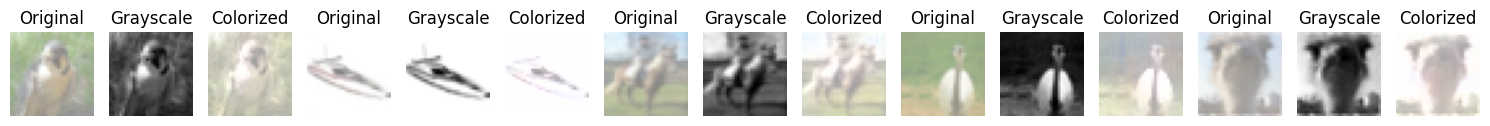

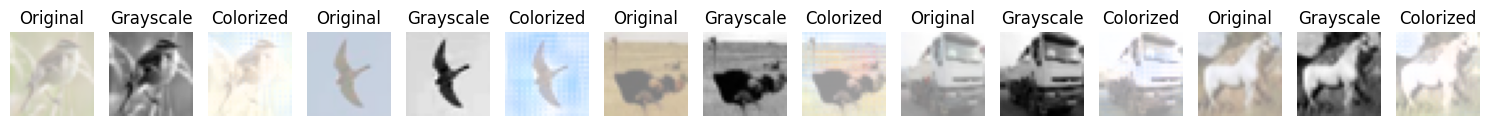

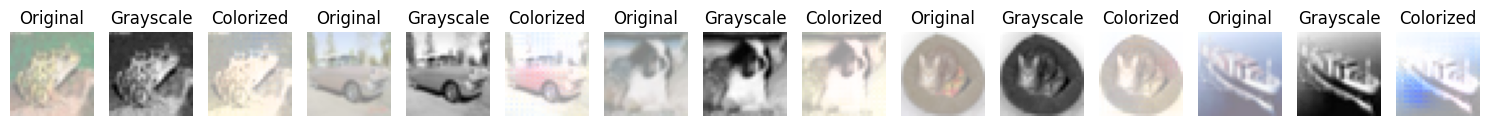

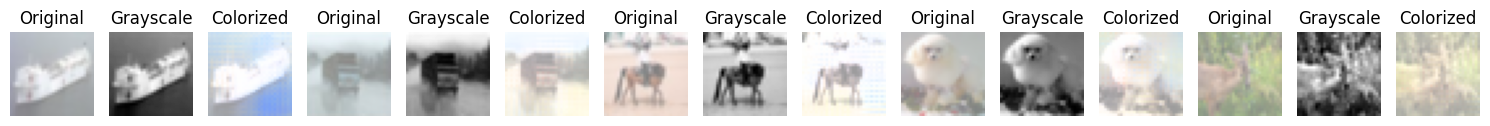

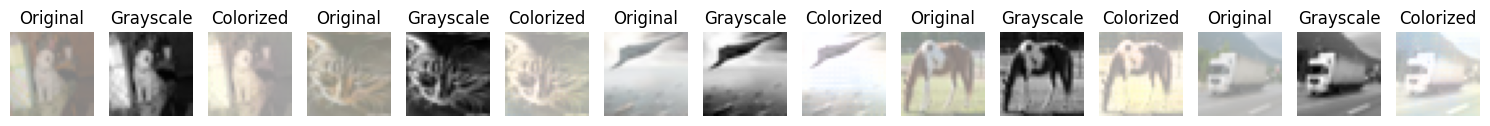

In [8]:
with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        grayscale_images = rgb_to_gray(images).to(device)
        colorized_images = model(grayscale_images)


        grayscale_images_cpu = grayscale_images.cpu().squeeze(1)
        colorized_images_cpu = colorized_images.cpu()
        original_images_cpu = images.cpu()

        #colorized_images_cpu=scale_predicted_colors(colorized_images_cpu)
        colorized_images_cpu=exaggerate_colors(colorized_images_cpu)

        # Visualize the grayscale, colorized, and original images
        visualize_all_three(original_images_cpu, grayscale_images_cpu, colorized_images_cpu)

        if i == 10:  # only do this for up to certain batch for demonstration purposes
            break

In [9]:
import os

# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current working directory:", current_directory)


Current working directory: /content


In [32]:
from google.colab import files

# Upload files from your local machine
uploaded = files.upload()

# List the uploaded files
for filename in uploaded.keys():
    print("Uploaded file:", filename)


Saving lolu.png to lolu.png
Uploaded file: lolu.png


In [33]:
import os

# List all files in the current directory
files = os.listdir("/content")
print("Files in the current directory:", files)


Files in the current directory: ['.config', '.ipynb_checkpoints', 'image-6.webp', '_colorized2.jpg', 'nnn.jpg', 'lolu.png', 'data', 'sample_data']


In [34]:
from PIL import Image

# Open the image. (Keep your image in the current directory. In my case, the image was horse.jpg)
img = Image.open('lolu.png')

# Convert the image to grayscale
gray_img = img.convert("L")

In [35]:
import torchvision.transforms as transforms

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    # If you need to normalize, uncomment the following line
    # transforms.Normalize(mean=[0.5], std=[0.5])  # Assuming you want to normalize to [-1, 1] range
])



In [36]:
# Apply the transformations
img_tensor = transform(gray_img).unsqueeze(0)  # Add a batch dimension

# Ensure the model is in evaluation mode
model.eval()

# Move the image tensor to the device where your model is (likely 'cuda' if using GPU)
img_tensor = img_tensor.to(device)

# Get the model's output
with torch.no_grad():
    colorized_tensor = model(img_tensor)


In [37]:
# Convert the tensor back to an image
colorized_img = transforms.ToPILImage()(colorized_tensor.squeeze(0).cpu())

# Optionally, save the image
colorized_img.save("_colorized2.jpg")


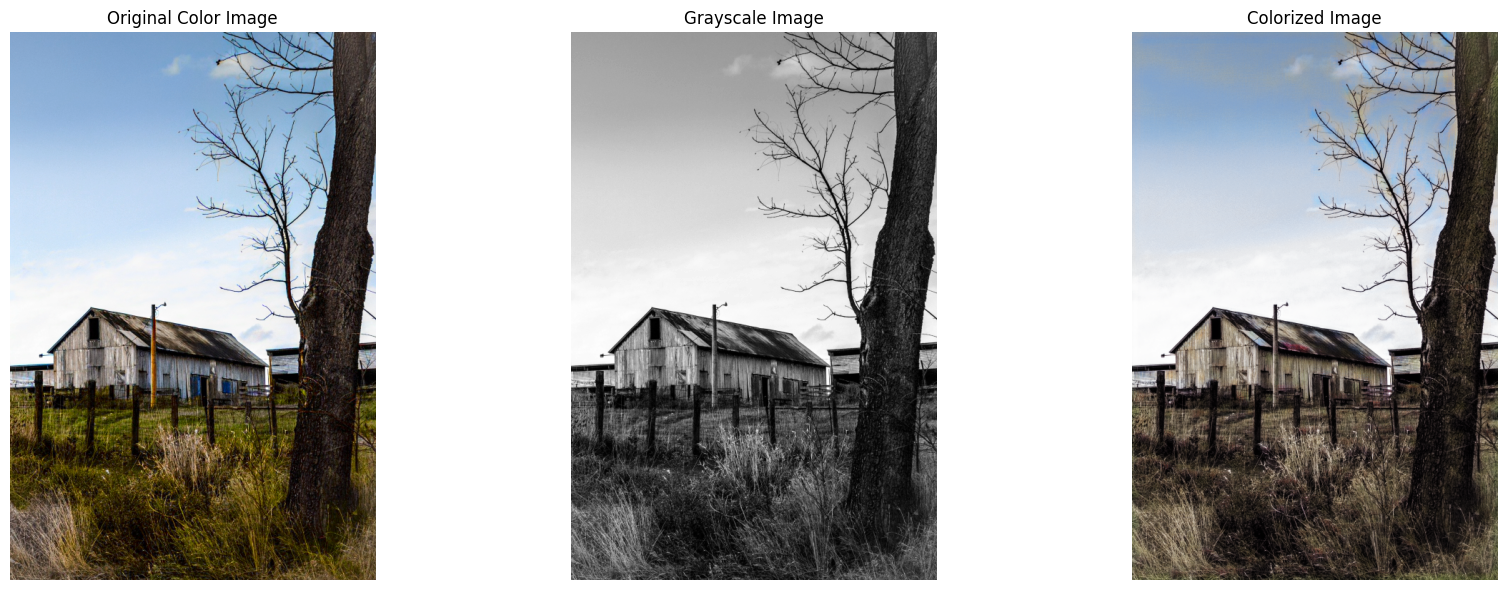

In [38]:
# Plotting the original, grayscale, and colorized images side-by-side
fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # Create a figure with 1 row and 3 columns

# Display original color image
ax[0].imshow(img)
ax[0].set_title("Original Color Image")
ax[0].axis('off')  # Hide axes

# Display grayscale image
ax[1].imshow(gray_img, cmap='gray')  # Since it's grayscale, use cmap='gray'
ax[1].set_title("Grayscale Image")
ax[1].axis('off')  # Hide axes

# Display colorized image
ax[2].imshow(colorized_img)
ax[2].set_title("Colorized Image")
ax[2].axis('off')  # Hide axes

plt.tight_layout()  # Adjust spacing
plt.show()